In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
import h5py

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = 'data/happy-house/'
os.makedirs('data/happy-house/models', exist_ok=True)
os.makedirs('cache/happy-house/tmp', exist_ok=True)
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [4]:
sz = 48
arch=resnext50
# data set downloaded from kaggle competition - https://www.kaggle.com/iarunava/happy-house-dataset
def load_dataset():
    train_data = h5py.File('data/happy-house/train_happy.h5', "r")
    x_train = np.array(train_data["train_set_x"][:]) 
    y_train = np.array(train_data["train_set_y"][:]) 

    test_data = h5py.File('data/happy-house/test_happy.h5', "r")
    x_test = np.array(test_data["test_set_x"][:])
    y_test = np.array(test_data["test_set_y"][:]) 
    
    y_train = y_train.reshape((1, y_train.shape[0]))
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return x_train, y_train, x_test, y_test

In [5]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [6]:
Y_train = Y_train.T.squeeze()
Y_test = Y_test.T.squeeze()
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_arrays(
        path=PATH,
        trn=(X_train, Y_train),
        val=(X_test, Y_test),
        bs=30,
        classes=Y_train,
        tfms=tfms)

In [7]:
data = get_data(sz)

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

  5%|▌         | 1/20 [00:00<00:14,  1.31it/s, loss=1.07]


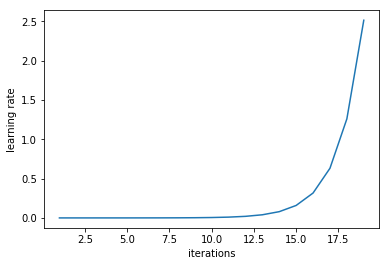

In [9]:
# finding optimal learning rate
lrf = learn.lr_find()
learn.sched.plot_lr()

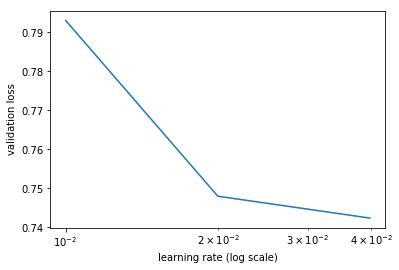

In [10]:
learn.sched.plot()

In [11]:
lr = 0.038
learn.fit(lr, 5, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                 
    0      0.600742   0.51059    0.8       
    1      0.628339   0.378149   0.893333                 
    2      0.50211    0.261331   0.94                     
    3      0.404538   0.193078   0.933333                 
    4      0.41436    0.259025   0.92                     
    5      0.389685   0.201744   0.9                        
    6      0.353408   0.231291   0.933333                 
    7      0.31348    0.134138   0.953333                 
    8      0.279238   0.177227   0.92                     
    9      0.248327   0.11978    0.966667                 
    10     0.215498   0.120035   0.96                     
    11     0.194384   0.123963   0.966667                 
    12     0.175264   0.119691   0.966667                 
    13     0.207676   0.13535    0.96                     
    14     0.256194   0.349808   0.846667                 
    15     0.24524    0.279233   0.906667                 
    16    

[0.13237517848610877, 0.9666666865348816]

In [12]:
learn.set_data(get_data(224))

In [13]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.119717   0.116435   0.973333  
    1      0.112068   0.102661   0.966667                 
    2      0.09827    0.084683   0.966667                  
    3      0.079253   0.074754   0.973333                  
    4      0.08878    0.07604    0.98                      
    5      0.084241   0.073992   0.973333                 
    6      0.077878   0.135541   0.966667                  
    7      0.08287    0.078119   0.973333                  
    8      0.083466   0.0663     0.973333                  
    9      0.06501    0.063143   0.973333                  
    10     0.058224   0.076933   0.973333                  
    11     0.069879   0.073494   0.973333                  
    12     0.066728   0.074105   0.973333                 
    13     0.072007   0.069042   0.973333                  
    14     0.063729   0.080178   0.973333                
    15     0.077937   0.079291   0.98                      
 

[0.10911554875783622, 0.9733333587646484]

In [14]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.98